In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from transformer_lens import HookedTransformer
from sae_lens import SAE
from src.agents.RAGAgent import embed_text

/home/ubuntu/investigaton-NLP/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import psutil
ram_gb = psutil.virtual_memory().total / (1024**3)
print(f"Total RAM: {ram_gb:.2f} GB")


Total RAM: 30.98 GB


# RAG

In [3]:
from dotenv import load_dotenv

load_dotenv()

True

In [18]:
def rag_separation(context, pos_query, neg_query):
    model = 'ollama/mxbai-embed-large'#'ollama/nomic-embed-text'
    z_context = np.array(embed_text(context, model))
    z_pos_query = np.array(embed_text(pos_query, model))
    z_neg_query = np.array(embed_text(neg_query, model))
    z_diff = z_pos_query - z_neg_query
    return np.dot(z_context, z_diff) / (np.linalg.norm(z_diff) + 1e-10)

In [14]:
def rag_similarity(context, query):
    model = 'ollama/mxbai-embed-large'#'ollama/nomic-embed-text'
    z_context = embed_text(context, model)
    z_query = embed_text(query, model)
    return np.dot(z_context, z_query)

In [ ]:
from openai import OpenAI
import numpy as np

client = OpenAI()

def openai_embed(text):
    """Return a numpy vector embedding using OpenAI text-embedding-3-large."""
    resp = client.embeddings.create(
        model="text-embedding-3-large",
        input=text,
    )
    return np.array(resp.data[0].embedding, dtype=np.float32)

def rag_separation(context, pos_query, neg_query):
    # Use OpenAI embeddings instead of ollama
    z_context = openai_embed(context)
    z_pos_query = openai_embed(pos_query)
    z_neg_query = openai_embed(neg_query)

    z_diff = z_pos_query - z_neg_query
    return np.dot(z_context, z_diff) / (np.linalg.norm(z_diff) + 1e-10)

context = '''
    User: I’m trying to choose between airlines for a long-haul flight to Tokyo. Any preference?
    Assistant: If you can, go with ANA. Their economy seats are more comfortable and the service is consistently excellent.
'''
pos_query = 'Which airline did you say was better for my long flight to Tokyo?'
neg_query = 'Which website did you say was best for finding cheap hotel deals in Tokyo?'

rag_separation(context, pos_query, neg_query)



np.float32(0.3131412)

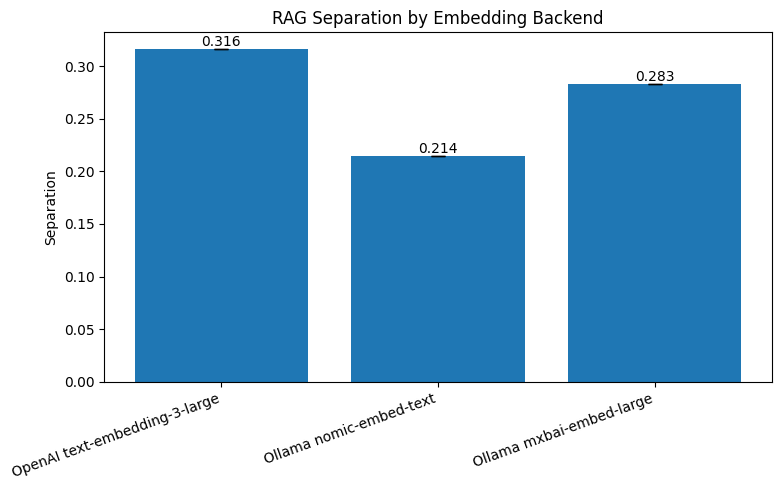

In [8]:
from openai import OpenAI
import numpy as np
import requests
import matplotlib.pyplot as plt

client = OpenAI()

def openai_embed(text):
    """Return a numpy vector embedding using OpenAI text-embedding-3-large."""
    resp = client.embeddings.create(
        model="text-embedding-3-large",
        input=text,
    )
    return np.array(resp.data[0].embedding, dtype=np.float32)

def ollama_embed(text, model_name):
    """Return a numpy vector embedding from an Ollama embedding model."""
    r = requests.post(
        "http://localhost:11434/api/embeddings",
        json={"model": model_name, "prompt": text},
        timeout=60,
    )
    r.raise_for_status()
    data = r.json()
    # Ollama's embeddings endpoint returns a single vector in "embedding"
    z = data["embedding"]
    return np.array(z / np.linalg.norm(z), dtype=np.float32) 

def embed(text, backend):
    """
    backend: one of
      - 'openai'
      - 'ollama-nomic'
      - 'ollama-mxbai'
    """
    if backend == "openai":
        return openai_embed(text)
    elif backend == "ollama-nomic":
        return ollama_embed(text, "nomic-embed-text")
    elif backend == "ollama-mxbai":
        return ollama_embed(text, "mxbai-embed-large")
    else:
        raise ValueError(f"Unknown backend: {backend}")

def rag_separation(backend, context, pos_query, neg_query):
    z_context   = embed(context, backend)
    z_pos_query = embed(pos_query, backend)
    z_neg_query = embed(neg_query, backend)

    z_diff = z_pos_query - z_neg_query
    return np.dot(z_context, z_diff) / (np.linalg.norm(z_diff) + 1e-10)

# === Examples ===
# You can add more (context, pos_query, neg_query) triples to this list
examples = [
    (
        """
        User: I’m trying to choose between airlines for a long-haul flight to Tokyo. Any preference?
        Assistant: If you can, go with ANA. Their economy seats are more comfortable and the service is consistently excellent.
        """,
        "Which airline did you say was better for my long flight to Tokyo?",
        "Which website did you say was best for finding cheap hotel deals in Tokyo?",
    ),
]

# === Backends to compare ===
backends = [
    ("openai",        "OpenAI text-embedding-3-large"),
    ("ollama-nomic",  "Ollama nomic-embed-text"),
    ("ollama-mxbai",  "Ollama mxbai-embed-large"),
]

separations = []
errors = []

for backend_key, backend_label in backends:
    vals = []
    for ctx, pos_q, neg_q in examples:
        val = rag_separation(backend_key, ctx, pos_q, neg_q)
        vals.append(val)
    vals = np.array(vals)
    separations.append(vals.mean())
    errors.append(vals.std(ddof=1) / np.sqrt(len(vals)) if len(vals) > 1 else 0.0)

# === Plot as bar plot ===
x = np.arange(len(backends))

plt.figure(figsize=(8, 5))
plt.bar(x, separations, yerr=errors, capsize=5)
plt.xticks(x, [b[1] for b in backends], rotation=20, ha="right")
plt.ylabel("Separation")
plt.title("RAG Separation by Embedding Backend")

# Optionally annotate exact values on top of bars
for i, sep in enumerate(separations):
    plt.text(i, sep, f"{sep:.3f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()


# SAE

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
sae_base_model_name = "EleutherAI/pythia-70m-deduped"
sae_release = "ctigges/pythia-70m-deduped__res-sm_processed"
sae_id      = "4-res-sm"
hook_name   = "blocks.4.hook_resid_post"

In [6]:
sae_base_model_name = "gemma-2b-it"
sae_release = "gemma-2b-it-res-jb"
sae_id = "blocks.12.hook_resid_post"
hook_name = "blocks.12.hook_resid_post" 

In [7]:
# sae_base_model_name = "google/gemma-2-2b-it"
# sae_release         = "gemma-scope-2b-pt-res-canonical"
# sae_id              = "layer_20/width_16k/canonical"
# hook_name           = "blocks.20.hook_resid_post"

sae_base_model = HookedTransformer.from_pretrained_no_processing(
    sae_base_model_name,
    device=device,
    dtype=torch.float16,   # float32 is safest on CPU
)

sae, sae_cfg, sparsity = SAE.from_pretrained(
    release=sae_release,
    sae_id=sae_id,
    device=device,
)
sae.eval()

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [00:37<00:00, 18.73s/it]


Loaded pretrained model gemma-2b-it into HookedTransformer


/tmp/ipykernel_1880/747108406.py:12: DeprecationWarning: Unpacking SAE objects is deprecated. SAE.from_pretrained() now returns only the SAE object. Use SAE.from_pretrained_with_cfg_and_sparsity() to get the config dict and sparsity as well.
  sae, sae_cfg, sparsity = SAE.from_pretrained(


StandardSAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [8]:
def sae_encode_text(
    model, 
    sae, 
    text, 
    hook_name, 
    prepend_bos=True, 
    method="mean",   # "mean", "max", or "topk"
    k=3
):
    with torch.no_grad():
        tokens = model.to_tokens(text, prepend_bos=prepend_bos)
        _, cache = model.run_with_cache(tokens, names_filter=[hook_name])
        acts = cache[hook_name]              # [batch, seq, d_model]
        acts_no_bos = acts[:, 1:, :]         # [batch, seq-1, d_model]
        feature_acts = sae.encode(acts_no_bos)  # [batch, seq-1, n_features]

        # ------- Aggregation methods -------
        if method == "mean":
            z = feature_acts.mean(dim=1)     # [B, F]

        elif method == "max":
            z = feature_acts.max(dim=1).values  # [B, F]

        elif method == "topk":
            seq_len = feature_acts.shape[1]
            k_eff = min(k, seq_len)
            topk_vals, _ = torch.topk(feature_acts, k=k_eff, dim=1)
            z = topk_vals.mean(dim=1)        # [B, F]

        else:
            raise ValueError(f"Unknown method '{method}', choose from 'mean', 'max', 'topk'.")

        # Final vector
        z = z.squeeze(0).cpu().numpy()
        return z/np.linalg.norm(z)

In [9]:
def tanimoto_similarity(z1, z2):
    dot = np.dot(z1, z2)
    denom = np.dot(z1, z1) + np.dot(z2, z2) - dot
    return dot / denom if denom != 0 else 0.0

def jaccard_similarity(z1, z2):
    f1 = set(np.nonzero(z1)[0])
    f2 = set(np.nonzero(z2)[0])
    return len(f1 & f2) / len(f1 | f2)

def sae_separation(context, pos_query, neg_query, method="topk", k=3):
    z_context = sae_encode_text(sae_base_model, sae, context, hook_name, method=method, k=k)
    z_pos_query = sae_encode_text(sae_base_model, sae, pos_query, hook_name, method=method, k=k)
    z_neg_query = sae_encode_text(sae_base_model, sae, neg_query, hook_name, method=method, k=k)
    z_diff = z_pos_query - z_neg_query
    return np.dot(z_context, z_diff) / (np.linalg.norm(z_diff) + 1e-10)
    #return tanimoto_similarity(z_context, z_pos_query), tanimoto_similarity(z_context, z_neg_query)
    #return jaccard_similarity(z_context, z_pos_query), jaccard_similarity(z_context, z_neg_query)

def sae_similarity(context, query, method="topk", k=3):
    z_context = sae_encode_text(sae_base_model, sae, context, hook_name, method=method, k=k)
    z_query = sae_encode_text(sae_base_model, sae, query, hook_name, method=method, k=k)
    return np.dot(z_context, z_query)

# SAE vs RAG

In [ ]:
def compare(context, pos_query, neg_query):
    return rag_separation(context, pos_query, neg_query), sae_separation(context, pos_query, neg_query)

In [28]:
context = 'What workouts did you recommend for increasing my  step count?'

pos_query = """
               {
                    "role": "user",
                    "content": "I'm trying to stay on top of my fitness goals and was wondering if you could recommend some workouts that can help me increase my step count. By the way, I've been tracking my progress with my new Fitbit Inspire HR, which I bought on February 15th - it's been really motivating me to move more!"
                },
                {
                    "role": "assistant",
                    "content": "Congratulations on taking the first step (pun intended!) towards a healthier lifestyle! I'm happy to help you with workout recommendations to increase your step count.\n\nFirstly, kudos on investing in a Fitbit Inspire HR! It's great that you've been tracking your progress and finding motivation from it.\n\nNow, let's get moving! Here are some effective workouts to help you boost your step count:\n\n1. **Brisk Walking**: Aim for a 30-minute brisk walk, 3-4 times a week. This will not only increase your step count but also improve cardiovascular health and burn calories.\n2. **High-Intensity Interval Training (HIIT)**: Incorporate HIIT workouts that involve short bursts of intense exercise followed by brief rest periods. This type of exercise can help you take more steps in less time. For example, try 30 seconds of jogging or jumping jacks followed by 30 seconds of rest.\n3. **Stair Climbing**: Find a staircase or a stairmaster at your local gym and climb for 10-15 minutes, 2-3 times a week. This will not only increase your step count but also strengthen your legs and glutes.\n4. **Bodyweight Exercises**: Incorporate bodyweight exercises like squats, lunges, and calf raises into your daily routine. These exercises can be done in short intervals throughout the day to increase your step count.\n5. **Walking Lunges**: Perform walking lunges while holding dumbbells or without weights. This exercise targets your legs and glutes, and you can do it anywhere, anytime.\n6. **Jumping Rope**: Jumping rope is a great cardio exercise that can be done in short intervals to increase your step count. Aim for 3-5 minutes of jumping rope, 2-3 times a week.\n7. **Dance-Based Workouts**: Try dance-based workouts like Zumba or Hip Hop Abs that involve high-energy movements to increase your step count and have fun while doing it!\n\nRemember to always listen to your body and start slowly, especially if you're new to exercise. It's essential to pace yourself and gradually increase the intensity and duration of your workouts.\n\nAdditionally, here are some tips to help you increase your step count throughout the day:\n\n* Take the stairs instead of the elevator at work or in your home.\n* Park your car farther away from your destination to get in a short walk.\n* Take a short walk during your lunch break or after dinner.\n* Do a few laps around your office or house during commercial breaks while watching TV.\n\nI hope these workouts and tips help you reach your fitness goals and stay motivated with your Fitbit Inspire HR!"
                },
                {
                    "role": "user",
                    "content": "I've been doing some yoga in the morning, and I'm curious to know if there are any specific yoga poses that can help improve my sleep quality."
                },
                {
                    "role": "assistant",
                    "content": "Yoga is an excellent way to start the day! Yes, certain yoga poses can indeed help improve sleep quality. Here are some sleep-promoting yoga poses you can incorporate into your morning routine:\n\n1. **Child's Pose (Balasana)**: This gentle, relaxing pose can help calm your mind and body, making it easier to fall asleep. Kneel on your mat, then sit back onto your heels. Stretch your arms out in front, lower your forehead to the ground, and breathe deeply.\n2. **Downward-Facing Dog (Adho Mukha Svanasana)**: This pose can help relax your neck, shoulders, and entire back, which can contribute to better sleep. Start on all fours, then lift your hips up and back, straightening your arms and legs. Hold for 5-10 breaths.\n3. **Pigeon Pose (Eka Pada Rajakapotasana)**: This pose can help release tension in your hips and lower back, which can improve sleep quality. Start on all fours, then bring one knee forward and place your ankle in front of the other knee. Lower your torso down, stretching the back leg. Hold for 5-10 breaths on each side.\n4. **Seated Forward Fold (Paschimottanasana)**: This pose can help calm your nervous system and promote relaxation. Sit on the floor with your legs straight out in front of you. Inhale, lengthen your spine, and then exhale, folding forward, reaching for your toes or shins. Hold for 5-10 breaths.\n5. **Legs Up The Wall Pose (Viparita Karani)**: This inverted pose can help calm your nervous system, reduce swelling in the legs, and promote relaxation. Lie on your back with your legs straight up against a wall. Stay for 5-10 minutes, breathing deeply.\n6. **Savasana (Corpse Pose)**: This pose is often referred to as the \"relaxation pose.\" It can help quiet your mind and body, preparing you for a restful night's sleep. Lie on your back, arms and legs relaxed, eyes closed, and focus on your breath. Stay for 5-10 minutes.\n7. **Cat-Cow Pose (Marjaryasana-Bitilasana)**: This gentle flow can help relax your spine, neck, and entire body, making it easier to fall asleep. Start on all fours, inhaling and arching your back (cat pose). Exhale, rounding your back and tucking your chin to your chest (cow pose). Repeat for 5-10 breaths.\n\nIn addition to these poses, consider the following tips to enhance your yoga practice for better sleep:\n\n* Practice yoga at a gentle, relaxing pace to promote calmness and reduce stimulating energy.\n* Avoid vigorous or energizing yoga practices, such as hot yoga or dynamic flows, close to bedtime.\n* Focus on deep, slow breathing throughout your practice to calm your nervous system.\n* End your practice with a relaxing Savasana or meditation to quiet your mind and body.\n\nRemember to listen to your body and modify or avoid any poses that cause discomfort or pain. Happy practicing!"
                },
                {
                    "role": "user",
                    "content": "That's really helpful, thanks! By the way, I've also been using a foam roller for post-workout stretching, and it's made a huge difference in reducing muscle soreness. I got it from Amazon, and it arrived on March 2nd. Anyway, I've been trying to use it at least three times a week, usually after my morning yoga sessions."
                },
                {
                    "role": "assistant",
                    "content": "Foam rolling is an excellent addition to your fitness routine! It's great to hear that it's been helping with reducing muscle soreness. Consistency is key, so it's awesome that you're aiming to use it at least three times a week.\n\nUsing a foam roller after your morning yoga sessions is a great way to enhance your stretching routine. It can help:\n\n1. **Reduce muscle soreness**: As you've already experienced, foam rolling can help reduce muscle soreness and inflammation.\n2. **Improve circulation**: Foam rolling can help increase blood flow to the affected areas, which can aid in the removal of waste products and promote healing.\n3. **Break up adhesions**: Foam rolling can help break up adhesions and knots in the muscles, which can improve range of motion and reduce stiffness.\n4. **Enhance recovery**: Foam rolling can help speed up the recovery process by reducing muscle spasms and promoting relaxation.\n\nRemember to focus on areas that feel tight or sore, and don't be afraid to experiment with different rolling techniques and pressures to find what works best for you.\n\nAs you continue to use your foam roller, keep in mind the following tips:\n\n* Start with gentle pressure and gradually increase as needed.\n* Roll slowly and control the movement to target specific areas.\n* Breathe deeply and relax while rolling to get the most benefit.\n* Don't roll over bony areas or joints.\n* Clean and maintain your foam roller regularly to prevent bacterial growth.\n\nIt's great that you're taking proactive steps to prioritize your fitness and recovery. Keep up the good work, and don't hesitate to reach out if you have any more questions or need further guidance!"
                },
                {
                    "role": "user",
                    "content": "I've also been tracking my blood pressure regularly with my new wireless blood pressure monitor from Omron, which I got on March 10th. I've been trying to keep an eye on it since my last check-up showed slightly higher than normal readings. Do you have any tips on how to lower blood pressure naturally?"
                },
                {
                    "role": "assistant",
                    "content": "Monitoring your blood pressure regularly is a great step towards taking control of your health! Congratulations on taking proactive measures to manage your blood pressure.\n\nYes, there are several ways to lower blood pressure naturally. Here are some tips that may help:\n\n1. **Maintain a healthy weight**: Excess weight can put extra strain on your heart and blood vessels, leading to higher blood pressure. Aim for a healthy body mass index (BMI) through a balanced diet and regular exercise.\n2. **Exercise regularly**: Regular physical activity can help lower blood pressure and improve overall cardiovascular health. Aim for at least 150 minutes of moderate-intensity exercise or 75 minutes of vigorous-intensity exercise per week.\n3. **Reduce sodium intake**: Consuming high amounts of sodium can increase blood pressure. Limit your daily sodium intake to less than 2,300 milligrams (mg) and ideally no more than 1,500 mg if you're at risk for high blood pressure.\n4. **Eat a balanced diet**: Focus on whole, unprocessed foods like fruits, vegetables, whole grains, lean proteins, and healthy fats. Avoid sugary drinks and foods high in saturated and trans fats.\n5. **Increase potassium intake**: Potassium can help lower blood pressure by balancing out the effects of sodium. Include potassium-rich foods like bananas, leafy greens, and sweet potatoes in your diet.\n6. **Stay hydrated**: Drinking enough water can help lower blood pressure by improving blood flow and reducing blood volume. Aim for at least eight glasses of water per day.\n7. **Manage stress**: Chronic stress can contribute to high blood pressure. Practice stress-reducing techniques like meditation, deep breathing, or yoga to help manage stress.\n8. **Get enough sleep**: Lack of sleep can increase blood pressure. Aim for 7-8 hours of sleep per night and prioritize a consistent sleep schedule.\n9. **Limit alcohol consumption**: Drinking too much alcohol can increase blood pressure. Limit your daily alcohol intake to no more than one drink for women and two drinks for men.\n10. **Quit smoking**: Smoking is a significant risk factor for high blood pressure. Quitting smoking can help lower blood pressure and improve overall health.\n\nRemember to consult with your healthcare provider before making any significant changes to your lifestyle or diet. They can provide personalized guidance and recommendations based on your individual health needs.\n\nIt's great that you're taking proactive steps to monitor and manage your blood pressure. Keep up the good work, and don't hesitate to reach out if you have any more questions or concerns!"
                },
                {
                    "role": "user",
                    "content": "I'm also experimenting with essential oils for stress relief, and I recently got a new diffuser on March 22nd. It's been a game-changer for unwinding before bed. I've been using a lavender and chamomile blend that I got from a local health food store."
                },
                {
                    "role": "assistant",
                    "content": "Essential oils can be a wonderful addition to your self-care routine! It's great that you're exploring natural ways to manage stress and promote relaxation.\n\nLavender and chamomile are both excellent choices for promoting calmness and reducing anxiety. The combination of the two can be particularly potent in promoting relaxation and improving sleep quality.\n\nUsing a diffuser is a great way to enjoy the benefits of essential oils, and it's wonderful that you've found it to be a game-changer for unwinding before bed. The gentle mist of the diffuser can help create a calming atmosphere, making it easier to relax and prepare for a restful night's sleep.\n\nRemember to always use high-quality, pure essential oils and follow the recommended usage guidelines to ensure safe and effective use. It's also a good idea to consult with a healthcare professional or a certified aromatherapist if you have any underlying health conditions or concerns.\n\nIn addition to lavender and chamomile, you might also consider exploring other essential oils that can promote relaxation and stress relief, such as:\n\n* Bergamot: Known for its calming and uplifting properties, bergamot can help reduce anxiety and stress.\n* Ylang-ylang: This sweet and soothing oil can help calm the mind and body, promoting feelings of relaxation and tranquility.\n* Frankincense: This earthy and woody oil can help reduce anxiety and stress, promoting a sense of calm and relaxation.\n\nRemember to always dilute essential oils in a carrier oil and perform a patch test before using them on your skin.\n\nIt's wonderful that you're taking proactive steps to prioritize your mental and emotional well-being. Keep exploring and finding what works best for you!"
                },
                {
                    "role": "user",
                    "content": "I've been meaning to get a flu shot, but I haven't gotten around to it yet. I need to schedule an appointment with my doctor for that. Do you have any tips on how to prepare for a flu shot appointment?"
                },
                {
                    "role": "assistant",
                    "content": "Getting a flu shot is an important step in protecting yourself and others from the flu. It's great that you're taking proactive steps to prioritize your health.\n\nPreparing for a flu shot appointment is relatively straightforward. Here are some tips to help you prepare:\n\n1. **Schedule your appointment**: As you mentioned, schedule an appointment with your doctor or a healthcare provider. You can also check with your local health department or pharmacy to see if they offer flu shots.\n2. **Check your insurance**: Verify that your insurance covers flu shots and what the copayment or coinsurance might be.\n3. **Dress appropriately**: Wear loose, easy-to-roll-up sleeves to make it easier to administer the shot.\n4. **Bring your insurance card and ID**: Make sure to bring your insurance card and a valid form of identification to your appointment.\n5. **Arrive early**: Plan to arrive 10-15 minutes before your scheduled appointment time to complete any necessary paperwork.\n6. **Be prepared for questions**: Your healthcare provider may ask you questions about your medical history, allergies, and any medications you're taking. Be prepared to provide this information.\n7. **Ask questions**: If you have any concerns or questions about the flu shot, be sure to ask your healthcare provider.\n8. **Plan for some downtime**: While the flu shot is a quick procedure, you may experience some minor side effects like soreness or redness at the injection site. Plan to take it easy for a few hours after the shot.\n\nSome general tips to keep in mind:\n\n* Flu shots are usually available from September to March, so it's best to get vaccinated early in the season.\n* The flu shot is recommended for everyone 6 months of age and older.\n* The flu shot cannot give you the flu, but it can take about two weeks for the vaccine to become effective.\n\nRemember, getting a flu shot is an important step in protecting yourself and others from the flu. By being prepared and taking proactive steps, you can help ensure a smooth and successful appointment.\n\nI hope this helps! If you have any more questions or concerns, feel free to ask."
                }
                """

neg_query = """
                {
                    "role": "user",
                    "content": "Can you give me numbered topics on radiation therapy that could be used to lecture a class on that subject ?"
                },
                {
                    "role": "assistant",
                    "content": "Sure, here are ten numbered topics on radiation therapy that could be used to lecture a class on that subject:\n\n1. Introduction to radiation therapy: history, principles, and applications\n2. Types of radiation therapy: external beam radiation therapy, internal radiation therapy, and systemic radiation therapy\n3. Radiation sources: photons, electrons, protons, and heavy ions\n4. Radiation delivery systems: linear accelerators, cyclotrons, brachytherapy sources, and radionuclide generators\n5. Radiation treatment planning: simulation, imaging, dose calculation, and quality assurance\n6. Radiation dose fractionation: conventional fractionation, hypofractionation, and stereotactic body radiation therapy\n7. Radiation side effects: acute and chronic effects, normal tissue toxicity, and late effects\n8. Radiation oncology team: radiation oncologists, medical physicists, radiation therapists, dosimetrists, and nurses\n9. Radiation safety: radiation protection, quality control, and emergency procedures\n10. Future directions in radiation therapy: advanced technologies, personalized medicine, and clinical trials"
                },
                {
                    "role": "user",
                    "content": "Pretend you are a teacher lecturing a class about topic 4, plan a class around that."
                },
                {
                    "role": "assistant",
                    "content": "Sure, here's a sample lesson plan for teaching Topic 4: Radiation Delivery Systems in Radiation Therapy:\n\nTitle: Radiation Delivery Systems in Radiation Therapy\n\nObjectives:\n\n* To introduce the different types of radiation delivery systems used in radiation therapy\n* To discuss the advantages and disadvantages of each type of delivery system\n* To provide an overview of the physics behind radiation delivery and the principles of dosimetry\n\nMaterials:\n\n* PowerPoint presentation\n* Handouts summarizing the main points of the lecture\n* Whiteboard and markers\n\nProcedure:\n\nI. Introduction (5 minutes)\n\n* Start the class by introducing the topic of radiation delivery systems and their importance in radiation therapy.\n* Ask the students to share any prior knowledge they may have about the different types of radiation delivery systems.\n\nII. Types of radiation delivery systems (20 minutes)\n\n* Use the PowerPoint presentation to introduce the different types of radiation delivery systems used in radiation therapy, including linear accelerators, cyclotrons, brachytherapy sources, and radionuclide generators.\n* For each type of delivery system, discuss the advantages and disadvantages, such as dose rate, beam energy, and treatment time.\n\nIII. Physics and dosimetry (20 minutes)\n\n* Explain the physics behind radiation delivery and the principles of dosimetry, including dose calculations, treatment planning, and quality assurance.\n* Use the whiteboard to illustrate key concepts and equations, such as the inverse square law and the depth-dose curve.\n\nIV. Case studies (10 minutes)\n\n* Use case studies to illustrate how different types of radiation delivery systems are used in clinical practice.\n* Ask the students to discuss how the choice of delivery system might impact the treatment plan and outcomes for each case.\n\nV. Conclusion (5 minutes)\n\n* Summarize the main points of the lecture and provide the handouts for the students to review.\n* Encourage the students to ask any remaining questions they may have about radiation delivery systems in radiation therapy.\n\nAssessment:\n\n* Give the students a short quiz or homework assignment to assess their understanding of the different types of radiation delivery systems and their advantages and disadvantages.\n* Ask the students to write a short reflection paper on how the choice of radiation delivery system might impact the success of a radiation therapy treatment plan."
                },
                {
                    "role": "user",
                    "content": "Can you write the texts for the PowerPoint presentation ?"
                },
                {
                    "role": "assistant",
                    "content": "Certainly! Here's an example PowerPoint presentation for Topic 4: Radiation Delivery Systems in Radiation Therapy:\n\nSlide 1: Radiation Delivery Systems in Radiation Therapy\n\nSlide 2: Introduction\n\n* Radiation delivery systems are the tools used to deliver radiation to the tumor site during radiation therapy.\n* The choice of delivery system depends on the tumor type, location, and stage, as well as the patient's overall health.\n\nSlide 3: Linear Accelerators (LINACs)\n\n* LINACs are the most common type of radiation delivery system used in radiation therapy.\n* They use electricity to produce high-energy X-rays or electrons that are directed at the tumor site.\n* Advantages: can be used to treat tumors in any part of the body, high dose rates, precise dose delivery.\n* Disadvantages: limited energy range, large equipment size, high cost.\n\nSlide 4: Cyclotrons\n\n* Cyclotrons are used to produce protons and other charged particles for radiation therapy.\n* They accelerate the particles to high energies and then direct them at the tumor site.\n* Advantages: high dose conformity, fewer side effects to healthy tissue, effective for some types of tumors.\n* Disadvantages: limited availability, high cost, large equipment size.\n\nSlide 5: Brachytherapy Sources\n\n* Brachytherapy involves placing a radioactive source directly into or near the tumor site.\n* Sources can be temporary or permanent and are usually inserted through a catheter or applicator.\n* Advantages: high dose rates, precise dose delivery, lower risk of side effects to healthy tissue.\n* Disadvantages: limited to certain types of tumors, risk of radiation exposure to healthcare workers, difficult to remove.\n\nSlide 6: Radionuclide Generators\n\n* Radionuclide generators are used to produce short-lived isotopes for imaging and therapy.\n* They consist of a parent isotope that decays into a daughter isotope, which can be used for therapy.\n* Advantages: relatively low cost, high purity of isotopes, convenient to use.\n* Disadvantages: limited availability of isotopes, risk of radiation exposure to healthcare workers, limited to certain types of tumors.\n\nSlide 7: Physics and Dosimetry\n\n* The physics of radiation delivery involves understanding how the radiation beam interacts with the patient's tissue.\n* Dosimetry is the process of calculating the radiation dose delivered to the tumor and surrounding tissue.\n* Key factors in dosimetry include beam energy, dose rate, and beam shape.\n\nSlide 8: Case Studies\n\n* Case studies can help illustrate how different types of radiation delivery systems are used in clinical practice.\n* For example, a LINAC might be used to treat a tumor in the brain, while a brachytherapy source might be used to treat a tumor in the cervix.\n\nSlide 9: Conclusion\n\n* Radiation delivery systems play a crucial role in radiation therapy.\n* The choice of delivery system depends on the tumor type, location, and stage, as well as the patient's overall health.\n* By understanding the advantages and disadvantages of each type of delivery system, radiation therapists can make informed treatment decisions."
                },
                {
                    "role": "user",
                    "content": "Can you plan a class about the secondary effects of external radiation therapy ?"
                },
                {
                    "role": "assistant",
                    "content": "Sure, here's a sample lesson plan for teaching about the secondary effects of external radiation therapy:\n\nTitle: Secondary Effects of External Radiation Therapy\n\nObjectives:\n\n* To introduce the concept of secondary effects of external radiation therapy\n* To discuss the different types of secondary effects and their causes\n* To provide an overview of the strategies for managing secondary effects\n\nMaterials:\n\n* PowerPoint presentation\n* Handouts summarizing the main points of the lecture\n* Whiteboard and markers\n\nProcedure:\n\nI. Introduction (5 minutes)\n\n* Start the class by introducing the topic of secondary effects of external radiation therapy and their importance in patient care.\n* Ask the students to share any prior knowledge they may have about the secondary effects of radiation therapy.\n\nII. Types of secondary effects (20 minutes)\n\n* Use the PowerPoint presentation to introduce the different types of secondary effects of external radiation therapy, including acute and chronic effects.\n* For each type of secondary effect, discuss the common symptoms, causes, and timelines.\n\nIII. Causes of secondary effects (20 minutes)\n\n* Discuss the underlying causes of secondary effects of external radiation therapy, such as damage to normal tissue and organs.\n* Use the whiteboard to illustrate key concepts, such as radiation-induced DNA damage and the role of inflammation in secondary effects.\n\nIV. Strategies for managing secondary effects (20 minutes)\n\n* Provide an overview of the strategies for managing secondary effects of external radiation therapy, including supportive care, medications, and radiation therapy techniques.\n* Discuss the importance of multidisciplinary care in managing secondary effects, including the roles of radiation oncologists, nurses, and other healthcare professionals.\n\nV. Case studies (10 minutes)\n\n* Use case studies to illustrate how different strategies for managing secondary effects are used in clinical practice.\n* Ask the students to discuss how the choice of management strategy might impact the patient's quality of life and treatment outcomes for each case.\n\nVI. Conclusion (5 minutes)\n\n* Summarize the main points of the lecture and provide the handouts for the students to review.\n* Encourage the students to ask any remaining questions they may have about secondary effects of external radiation therapy.\n\nAssessment:\n\n* Give the students a short quiz or homework assignment to assess their understanding of the different types of secondary effects of external radiation therapy and their causes.\n* Ask the students to write a short reflection paper on the importance of managing secondary effects in patient care.\n\nNote: Depending on the length of the class, the amount of material covered in each section can be adjusted accordingly. Additionally, case studies can be customized to focus on specific types of cancer or treatment scenarios.\n\nI hope this helps you plan your class!"
                }
                """

In [29]:
rag_separation(context, pos_query, neg_query)

np.float64(0.49211437392894025)

In [30]:
sae_separation(context, pos_query, neg_query, method='mean')

np.float32(0.11334021)

In [21]:
examples_1 = [
    {
        "context": (
            "User: Which one would you say is the best for a romantic dinner?\n"
            "Assistant: I would recommend Roscioli. It has a cozy and intimate atmosphere "
            "with soft lighting and excellent service."
        ),
        "pos_query": "Can you remind me of the romantic restaurant in Rome you recommended for dinner?",
        "neg_query": "Can you remind me which museum in Rome you said had the best collection of ancient sculptures?",
    },
    {
        "context": (
            "User: I want a compact camera for street photography, something small but with great image quality. "
            "Any suggestions?\n"
            "Assistant: You might really like the Ricoh GR III. It’s very pocketable and has an excellent "
            "28mm-equivalent lens that’s great for street shots."
        ),
        "pos_query": "What was the small street photography camera you suggested, the one with the 28mm lens?",
        "neg_query": "What was the tripod you recommended for long-exposure night photography?",
    },
    {
        "context": (
            "User: My API is slowing down under load. Could it be the Docker configuration?\n"
            "Assistant: It’s possible. I’d start by checking the CPU and memory limits on the container "
            "and see if you’re hitting them during peak traffic."
        ),
        "pos_query": "What did you say I should look at in my Docker setup to understand why the API slows down?",
        "neg_query": "What did you say I should look at in my Postgres configuration to reduce slow queries?",
    },
    {
        "context": (
            "User: I’m trying to choose between airlines for a long-haul flight to Tokyo. Any preference?\n"
            "Assistant: If you can, go with ANA. Their economy seats are more comfortable and the service "
            "is consistently excellent."
        ),
        "pos_query": "Which airline did you say was better for my long flight to Tokyo?",
        "neg_query": "Which website did you say was best for finding cheap hotel deals in Tokyo?",
    },
    {
        "context": (
            "User: I have an exam in statistical mechanics next month and I’m overwhelmed. "
            "How should I structure my study time?\n"
            "Assistant: Focus first on the partition function and the main ensembles. Then spend time on typical "
            "problems with phase transitions and critical exponents, and leave the more exotic topics for last."
        ),
        "pos_query": "What did you tell me to prioritize when studying for my statistical mechanics exam?",
        "neg_query": "What did you tell me to prioritize when preparing my job interview presentation?",
    },
    {
        "context": (
            "User: I need a laptop for machine learning experiments. Any particular specs I should aim for?\n"
            "Assistant: Try to get at least 32 GB of RAM and an NVIDIA GPU with at least 8 GB of VRAM. "
            "That will make training small to medium models much smoother."
        ),
        "pos_query": "Can you remind me what specs you recommended for a laptop to run my ML experiments?",
        "neg_query": "Can you remind me what specs you recommended for a monitor for photo editing?",
    },
    {
        "context": (
            "User: I’m visiting Barcelona for a few days and want a nice day hike nearby. Any suggestions?\n"
            "Assistant: You could hike in Montserrat. It’s about an hour from the city by train and has beautiful "
            "mountain views and well-marked trails."
        ),
        "pos_query": "What was the hiking spot near Barcelona you mentioned that I can reach by train?",
        "neg_query": "What was the beach town near Barcelona you mentioned that’s good for a day of swimming?",
    },
    {
        "context": (
            "User: I want a sci-fi novel that’s thoughtful but still fun to read. Any ideas?\n"
            "Assistant: You might enjoy \"The Three-Body Problem.\" It mixes hard science with a very engaging story."
        ),
        "pos_query": "Which sci-fi book did you recommend that combines hard science with an engaging story?",
        "neg_query": "Which non-fiction book did you recommend for learning basic investing principles?",
    },

    {
        "context": (
            "User: I'm finally replacing my old laptop. Do you think 16GB of RAM is enough for light coding?\n"
            "Assistant: For light coding it's fine, but if you plan to do ML experiments or heavy multitasking, "
            "I'd recommend going for 32GB instead."
        ),
        "pos_query": "What was the RAM amount you recommended for heavier ML coding workloads?",
        "neg_query": "What was the phone model you said had the best battery life for traveling?"
    },
    {
        "context": (
            "User: I'm planning a trip to Florence. Is there a museum I absolutely shouldn't miss?\n"
            "Assistant: Definitely visit the Uffizi Gallery. It's one of the most important art museums in the world."
        ),
        "pos_query": "What was the museum in Florence you told me I shouldn't miss?",
        "neg_query": "Which restaurant in Florence did you say had the best bistecca alla fiorentina?"
    },

    {
        "context": (
            "User: I'm choosing a film camera for trying analog photography. Any recommendation?\n"
            "Assistant: The Nikon FE is a great starting point. Reliable, sturdy, and easy to use."
        ),
        "pos_query": "Which beginner film camera did you recommend to me?",
        "neg_query": "What digital camera did you say was best for recording 4K video?"
    },

    {
        "context": (
            "User: My sourdough bread keeps coming out too dense. What should I fix?\n"
            "Assistant: Try increasing the hydration slightly and give the dough a longer bulk fermentation."
        ),
        "pos_query": "What did you say I should adjust in my sourdough recipe to avoid dense loaves?",
        "neg_query": "What did you say I should adjust in my lasagna recipe to make the sauce thicker?"
    },

    {
        "context": (
            "User: I'm thinking of learning a second programming language after Python. Suggestions?\n"
            "Assistant: Go with Rust. It forces good habits and teaches you a lot about memory safety and performance."
        ),
        "pos_query": "Which programming language did you recommend I learn after Python?",
        "neg_query": "Which photo editing software did you recommend for color grading RAW images?"
    },

    {
        "context": (
            "User: I want something philosophical but easy to read. Any book recommendations?\n"
            "Assistant: You might like 'The Stranger' by Albert Camus. It's short but very thought-provoking."
        ),
        "pos_query": "Which philosophical novel did you recommend that was short and thought-provoking?",
        "neg_query": "Which fantasy novel did you recommend that had dragons and magic?"
    },

    {
        "context": (
            "User: I'm trying intermittent fasting for the first time. Any tips for beginners?\n"
            "Assistant: Start with a 14:10 schedule and gradually increase the fasting window if you feel comfortable."
        ),
        "pos_query": "What fasting schedule did you say was good for beginners?",
        "neg_query": "What running schedule did you say was good for preparing a marathon?"
    },

    {
        "context": (
            "User: My code is running much slower after I moved to Windows from Linux. Any ideas?\n"
            "Assistant: Check whether Windows Defender is scanning your Python files. That often slows down execution."
        ),
        "pos_query": "What did you say might be slowing down my Python code on Windows?",
        "neg_query": "What did you say might be causing my internet to disconnect randomly?"
    },

    {
        "context": (
            "User: I'm decorating my apartment and want a minimalist look. Any advice?\n"
            "Assistant: Stick to neutral colors and reduce visible clutter. Furniture with clean lines works best."
        ),
        "pos_query": "What kind of design recommendations did you give me for a minimalist apartment?",
        "neg_query": "What kind of exercise recommendations did you give me for building muscle?"
    },

    {
        "context": (
            "User: I'm learning guitar but my fingers hurt a lot. Is that normal?\n"
            "Assistant: Yes, totally normal. You'll develop calluses after a few weeks and the pain will decrease."
        ),
        "pos_query": "What did you say would eventually stop hurting when practicing guitar?",
        "neg_query": "What did you say would eventually improve if I keep practicing my coding skills?"
    },
    {
        "context": (
            "User: I'm trying to pick a gift for someone who loves astronomy. Any ideas?\n"
            "Assistant: A high-quality star map poster or a beginner telescope would make a great astronomy gift."
        ),
        "pos_query": "What astronomy-themed gift did you say would be a good idea?",
        "neg_query": "What cooking tool did you recommend for making homemade pasta?"
    },
    {
        "context": (
            "User: My neck hurts after long coding sessions. What should I adjust?\n"
            "Assistant: Try raising your monitor to eye level and consider using an ergonomic chair."
        ),
        "pos_query": "What posture adjustment did you say would help with my neck pain while coding?",
        "neg_query": "What adjustment did you say would help keep my sourdough starter active?"
    },
    {
        "context": (
            "User: I need something lightweight to read on the plane. Any book that's easy to get into?\n"
            "Assistant: 'The Alchemist' is a great choice—short, inspiring, and very readable."
        ),
        "pos_query": "Which easy-to-read book did you recommend for my flight?",
        "neg_query": "Which technical manual did you recommend for learning Kubernetes?"
    },
    {
        "context": (
            "User: I'm considering adopting a dog. Anything I should plan for in advance?\n"
            "Assistant: Make sure you have time for daily walks and a consistent routine—they really need structure."
        ),
        "pos_query": "What did you tell me dogs need in terms of routine?",
        "neg_query": "What did you tell me SQL databases need in terms of indexing?"
    },
    {
        "context": (
            "User: I'm struggling to stay awake while studying. Any tips?\n"
            "Assistant: Try the Pomodoro technique and avoid studying lying down—it makes a big difference."
        ),
        "pos_query": "What study strategy did you say could help me stay alert?",
        "neg_query": "What financial strategy did you say could help me save for retirement?"
    },
    {
        "context": (
            "User: I'm going to Iceland in winter. What should I absolutely pack?\n"
            "Assistant: Thermal layers and waterproof boots are must-haves for that season."
        ),
        "pos_query": "What essential items did you tell me to pack for Iceland?",
        "neg_query": "What essential items did you tell me to buy for setting up a home gym?"
    },
    {
        "context": (
            "User: I'm doing my first 10k race. Any advice on pacing?\n"
            "Assistant: Start slower than you think and gradually increase your pace after the halfway point."
        ),
        "pos_query": "How did you say I should pace myself for the 10k?",
        "neg_query": "How did you say I should pace myself when learning jazz piano?"
    },
    {
        "context": (
            "User: My houseplants keep dying. What am I doing wrong?\n"
            "Assistant: You're likely overwatering. Most indoor plants prefer to dry out between waterings."
        ),
        "pos_query": "What plant care mistake did you say I was probably making?",
        "neg_query": "What mistake did you say I was making in my SQL queries?"
    },
    {
        "context": (
            "User: I'm upgrading my bike and want to go faster. What should I change first?\n"
            "Assistant: Swapping to lighter tires usually makes a noticeable difference."
        ),
        "pos_query": "What upgrade did you say would help my bike go faster?",
        "neg_query": "What upgrade did you say would help my computer run Photoshop?"
    },
    {
        "context": (
            "User: My meditation practice feels unfocused lately. Any suggestions?\n"
            "Assistant: Try guided audio sessions—they help bring structure when your mind wanders easily."
        ),
        "pos_query": "What did you suggest to help me stay focused during meditation?",
        "neg_query": "What did you suggest to help me clean hard water stains?"
    },
    {
        "context": (
            "User: I want to start eating healthier but don’t know where to begin.\n"
            "Assistant: Start by adding more vegetables to each meal and cutting back on sugary drinks."
        ),
        "pos_query": "What first step did you recommend for eating healthier?",
        "neg_query": "What first step did you recommend for learning Java?"
    },
    {
        "context": (
            "User: My backpacking tent feels cramped. Should I get a bigger one?\n"
            "Assistant: Yes—going one person size above your actual group usually feels much more comfortable."
        ),
        "pos_query": "What tent sizing advice did you give me for backpacking?",
        "neg_query": "What sizing advice did you give me for choosing a winter coat?"
    },
    {
        "context": (
            "User: I'm losing motivation to exercise. Any trick to keep going?\n"
            "Assistant: Setting very small daily goals works well—even just 10 minutes counts."
        ),
        "pos_query": "What was the motivational trick you suggested for exercise?",
        "neg_query": "What motivational trick did you suggest for writing my thesis?"
    },
    {
        "context": (
            "User: I think my espresso tastes sour. What should I adjust?\n"
            "Assistant: Try grinding a bit finer and increasing the extraction time."
        ),
        "pos_query": "How did you say I could fix sour espresso?",
        "neg_query": "How did you say I could fix a leaky faucet?"
    },
    {
        "context": (
            "User: I'm redoing my desk setup and want it to be more ergonomic.\n"
            "Assistant: Keep your wrists neutral and make sure your elbows rest at a 90-degree angle."
        ),
        "pos_query": "What ergonomic tips did you give me for my desk setup?",
        "neg_query": "What ergonomic tips did you give me for improving my running stride?"
    },
    {
        "context": (
            "User: I'm choosing a gift for someone who loves cooking.\n"
            "Assistant: A high-quality chef’s knife is always appreciated and lasts for years."
        ),
        "pos_query": "Which cooking-related gift did you recommend?",
        "neg_query": "Which travel-related gift did you recommend for someone visiting Patagonia?"
    },
    {
        "context": (
            "User: I'm having trouble sleeping lately. Any ideas?\n"
            "Assistant: Try keeping your room cooler and reducing screen time before bed."
        ),
        "pos_query": "What did you say I should adjust to improve my sleep?",
        "neg_query": "What did you say I should adjust to improve my coding performance?"
    },
    {
        "context": (
            "User: My cat keeps scratching the couch. What should I do?\n"
            "Assistant: Provide a scratching post and reward them when they use it."
        ),
        "pos_query": "What solution did you suggest for my cat scratching the couch?",
        "neg_query": "What solution did you suggest for fixing my slow WiFi?"
    },
    {
        "context": (
            "User: I'm getting into baking and want an easy recipe to start.\n"
            "Assistant: Banana bread is perfect for beginners—very forgiving and delicious."
        ),
        "pos_query": "What beginner-friendly baking recipe did you recommend?",
        "neg_query": "What high-protein meal did you recommend for post-workout recovery?"
    },
    {
        "context": (
            "User: I'm worried my resume looks too empty. Any improvements?\n"
            "Assistant: Add a small projects section—anything you’ve built, even personal experiments, helps a lot."
        ),
        "pos_query": "What improvement did you suggest to make my resume look stronger?",
        "neg_query": "What improvement did you suggest to make my standing desk more stable?"
    },
    {
        "context": (
            "User: I'm debating whether to learn piano or guitar first.\n"
            "Assistant: I'd start with guitar—it's more intuitive for beginners and you’ll see progress quickly."
        ),
        "pos_query": "Which instrument did you say I should learn first?",
        "neg_query": "Which instrument did you say I should avoid learning first because it's too intuitive?",
    },
    {
        "context": (
            "User: I'm choosing a tablet mainly for reading scientific papers.\n"
            "Assistant: Go with the iPad Air—the screen size is perfect and the battery life is excellent."
        ),
        "pos_query": "Which tablet did you recommend for reading papers?",
        "neg_query": "Which papers did you recommend I read on the tablet?",
    },
    {
        "context": (
            "User: I'm trying to cut down on caffeine. Any replacement for morning coffee?\n"
            "Assistant: Try green tea—it has less caffeine but still gives a gentle boost."
        ),
        "pos_query": "What drink did you suggest as a lighter caffeine alternative?",
        "neg_query": "What caffeine alternative did you suggest avoiding in the morning?",
    },
    {
        "context": (
            "User: I'm rebuilding my PC and need a good CPU for programming.\n"
            "Assistant: The Ryzen 7 series is a great option—excellent multithreaded performance."
        ),
        "pos_query": "Which CPU did you say is a good option for programming?",
        "neg_query": "Which programming option did you say is good for the CPU?",
    },
    {
        "context": (
            "User: My sleep schedule is completely off. Any starting point?\n"
            "Assistant: Try going to bed at the same time each night and avoid screens one hour before."
        ),
        "pos_query": "What did you say I should do before bed to fix my sleep schedule?",
        "neg_query": "What did you say would happen if I fixed my sleep schedule before going to bed?",
    },
    {
        "context": (
            "User: I'm new to resistance training. What weight should I begin with?\n"
            "Assistant: Start with something light enough to keep good form—usually 2–5 kg."
        ),
        "pos_query": "What starting weight did you recommend for resistance training?",
        "neg_query": "What resistance did you suggest for training starting weights?",
    },
    {
        "context": (
            "User: I'm overwhelmed choosing a budget microphone.\n"
            "Assistant: The Audio-Technica ATR2100x is fantastic for the price and very beginner-friendly."
        ),
        "pos_query": "Which budget microphone did you recommend?",
        "neg_query": "Which budget did you recommend for choosing a microphone?",
    },
    {
        "context": (
            "User: I'm doing my first half marathon and unsure about shoes.\n"
            "Assistant: Get something with good cushioning—Nike Pegasus is a safe choice for beginners."
        ),
        "pos_query": "Which running shoe did you say is good for a beginner?",
        "neg_query": "Which beginner did you say is good for running shoes?",
    },
    {
        "context": (
            "User: I'm planning a weekend trip and want something relaxing.\n"
            "Assistant: A small cabin near the lake is perfect—quiet, peaceful, and not far from the city."
        ),
        "pos_query": "What relaxing weekend option did you recommend?",
        "neg_query": "What weekend did you recommend relaxing rather than taking a trip?",
    },
    {
        "context": (
            "User: I'm learning to cook and want something simple.\n"
            "Assistant: Start with pasta aglio e olio—few ingredients and hard to mess up."
        ),
        "pos_query": "Which simple dish did you suggest I start cooking?",
        "neg_query": "Which cooking did you suggest I start with because it's too simple?",
    },
    {
        "context": (
            "User: I'm trying intermittent fasting but don't know where to begin.\n"
            "Assistant: Begin with a 14:10 schedule and see how your body responds."
        ),
        "pos_query": "What fasting schedule did you say I should begin with?",
        "neg_query": "What schedule did you say should begin fasting after I eat?",
    },
    {
        "context": (
            "User: I'm having trouble staying focused at work.\n"
            "Assistant: Try working in 25-minute blocks with short breaks—Pomodoro is very effective."
        ),
        "pos_query": "What technique did you recommend to help me focus?",
        "neg_query": "What focus did you recommend to help me learn the Pomodoro technique?",
    }
]

Los siguientes son examples con dos preguntas: una que se responde con el contexto y la otra super lejos semánticamente.

In [22]:
examples_2 = [
    {
        "context": (
            "User: Could you explain why some telescopes use a curved secondary mirror?\n"
            "Assistant: Certainly! A curved secondary helps correct optical aberrations and can "
            "redirect light into a more compact focal plane design."
        ),
        "pos_query": "What does the curved secondary mirror help correct?",
        "neg_query": "How many novels did Charles Dickens publish in his lifetime?"
    },
    {
        "context": (
            "User: How do I prevent numerical instability in my finite-difference simulation?\n"
            "Assistant: You can reduce instability by decreasing the time step and ensuring the "
            "Courant condition is satisfied."
        ),
        "pos_query": "Which condition must be satisfied to reduce instability?",
        "neg_query": "Where do hummingbirds migrate during the winter season?"
    },
    {
        "context": (
            "User: Why do neural networks sometimes fail to generalize well?\n"
            "Assistant: Often it's due to overfitting, where the model memorizes training data "
            "instead of learning underlying patterns."
        ),
        "pos_query": "What is the phenomenon called when the model memorizes training data?",
        "neg_query": "What materials were used to build Viking longships?"
    },
    {
        "context": (
            "User: What does the event horizon represent in a black hole?\n"
            "Assistant: It marks the boundary beyond which no information or light can escape "
            "the gravitational pull."
        ),
        "pos_query": "What cannot escape past the event horizon?",
        "neg_query": "Which planet has the shortest day in our solar system?"
    },
    {
        "context": (
            "User: How can I speed up convergence in gradient descent?\n"
            "Assistant: Using momentum or adaptive learning rate methods like Adam can help "
            "accelerate convergence."
        ),
        "pos_query": "Which optimizer uses adaptive learning rates?",
        "neg_query": "When did the first Olympic marathon take place?"
    },
    {
        "context": (
            "User: What determines the luminosity of a main-sequence star?\n"
            "Assistant: Its mass is the key factor, as it dictates the rate of nuclear fusion "
            "in the core."
        ),
        "pos_query": "What property mainly determines a main-sequence star’s luminosity?",
        "neg_query": "How does a chef make traditional miso paste at home?"
    },
    {
        "context": (
            "User: Why is normalization important for training deep networks?\n"
            "Assistant: Normalization keeps input scales consistent, which stabilizes gradients "
            "and speeds up training."
        ),
        "pos_query": "How does normalization affect gradient behavior?",
        "neg_query": "What year was aluminum first commercially produced?"
    },
    {
        "context": (
            "User: How does the Doppler effect influence radial velocity measurements?\n"
            "Assistant: It causes spectral lines to shift depending on whether the star moves "
            "toward or away from the observer."
        ),
        "pos_query": "What happens to spectral lines when a star moves toward us?",
        "neg_query": "Which species of cactus grows the tallest in the Sahara Desert?"
    },
    {
        "context": (
            "User: What's the purpose of dropout in neural network training?\n"
            "Assistant: Dropout reduces overfitting by randomly deactivating neurons during "
            "training."
        ),
        "pos_query": "How does dropout help prevent overfitting?",
        "neg_query": "Which dynasty built most of the major pyramids in ancient Egypt?"
    },
    {
        "context": (
            "User: Why do astronomers prefer CCDs over photographic plates?\n"
            "Assistant: CCDs offer higher sensitivity and better linearity, enabling more "
            "precise measurements."
        ),
        "pos_query": "What advantage do CCDs provide to improve measurement precision?",
        "neg_query": "What type of soil produces the spiciest varieties of chili peppers?"
    },
    {
        "context": (
            "User: What is the function of the transformer architecture’s attention mechanism?\n"
            "Assistant: It allows the model to weight different parts of the input sequence "
            "based on relevance."
        ),
        "pos_query": "What does the attention mechanism assign to different parts of a sequence?",
        "neg_query": "Which European country consumes the most mineral water per capita?"
    },
    {
        "context": (
            "User: How do tidal forces affect moons orbiting giant planets?\n"
            "Assistant: Tidal forces can induce heating, drive geological activity, and even "
            "maintain orbital resonance."
        ),
        "pos_query": "What can tidal heating generate on a moon?",
        "neg_query": "What fabrics are most durable for making outdoor hammocks?"
    },
    {
        "context": (
            "User: Why is regularization useful in linear regression?\n"
            "Assistant: It penalizes large coefficients, reducing variance and improving "
            "generalization."
        ),
        "pos_query": "How does regularization affect large coefficients?",
        "neg_query": "When were the first electric trams introduced in South America?"
    },
    {
        "context": (
            "User: What limits the resolution of a radio interferometer?\n"
            "Assistant: The maximum baseline—the distance between antennas—sets the resolving "
            "power."
        ),
        "pos_query": "What parameter of an interferometer determines its resolving power?",
        "neg_query": "Which ingredients are essential for a traditional Greek spanakopita?"
    },
    {
        "context": (
            "User: What causes aliasing in digital signal processing?\n"
            "Assistant: Undersampling a signal below the Nyquist rate leads to overlapping "
            "frequency components."
        ),
        "pos_query": "What happens if you sample below the Nyquist rate?",
        "neg_query": "How are aristocratic titles inherited in medieval England?"
    },
    {
        "context": (
            "User: Why do we use convolutional layers for image data?\n"
            "Assistant: They exploit spatial locality by applying filters across local patches."
        ),
        "pos_query": "What spatial property do convolutions exploit?",
        "neg_query": "What is the main fermentation agent in kombucha?"
    },
    {
        "context": (
            "User: How does redshift relate to cosmic expansion?\n"
            "Assistant: As space expands, wavelengths stretch, causing galaxies to appear "
            "redshifted."
        ),
        "pos_query": "Why do wavelengths stretch during cosmic expansion?",
        "neg_query": "How did Renaissance painters create ultramarine pigment?"
    },
    {
        "context": (
            "User: What's the benefit of batch normalization?\n"
            "Assistant: It reduces internal covariate shift and stabilizes learning dynamics."
        ),
        "pos_query": "What shift does batch normalization help reduce?",
        "neg_query": "What animals are most commonly featured in Inuit stone carvings?"
    },
    {
        "context": (
            "User: Why do gas giants emit more heat than they receive from the Sun?\n"
            "Assistant: They release energy from slow gravitational contraction, known as "
            "Kelvin–Helmholtz heating."
        ),
        "pos_query": "What type of contraction generates extra heat on gas giants?",
        "neg_query": "Which country produces the largest amount of organic saffron?"
    },
    {
        "context": (
            "User: How does quantization affect neural network inference?\n"
            "Assistant: It reduces precision of weights and activations, speeding up computation "
            "but possibly reducing accuracy."
        ),
        "pos_query": "What aspect of model parameters does quantization reduce?",
        "neg_query": "How do artisans craft traditional Venezuelan cuatro instruments?"
    },
    {
        "context": (
            "User: What drives convection in stellar interiors?\n"
            "Assistant: Temperature gradients create buoyant forces that move plasma upward."
        ),
        "pos_query": "What creates the buoyant forces inside stars?",
        "neg_query": "Which ocean is home to the deepest hydrothermal vents?"
    },
    {
        "context": (
            "User: Why is ensemble learning often more robust?\n"
            "Assistant: Combining multiple models averages out errors and reduces variance."
        ),
        "pos_query": "How does combining models affect variance?",
        "neg_query": "What spices are traditionally used in Ethiopian berbere?"
    },
    {
        "context": (
            "User: How do adaptive optics systems improve astronomical imaging?\n"
            "Assistant: They dynamically adjust mirror shapes to compensate for atmospheric "
            "distortion."
        ),
        "pos_query": "What do adaptive optics systems correct in real time?",
        "neg_query": "What materials are commonly used to build suspension bridges?"
    },
    {
        "context": (
            "User: What is the purpose of a learning rate scheduler?\n"
            "Assistant: It adjusts the learning rate over time to improve training stability and "
            "convergence."
        ),
        "pos_query": "What is being adjusted during training?",
        "neg_query": "Which birds have the longest recorded wingspan?"
    },
    {
        "context": (
            "User: Why do spiral galaxies have distinct arms?\n"
            "Assistant: Density waves compress gas and stars, creating the patterned arms."
        ),
        "pos_query": "What produces the compression that forms spiral arms?",
        "neg_query": "What ingredients are required to make traditional French nougat?"
    },
    {
        "context": (
            "User: How does L2 regularization influence weight updates?\n"
            "Assistant: It adds a penalty proportional to weight magnitude, encouraging smaller "
            "values."
        ),
        "pos_query": "What type of penalty does L2 regularization impose?",
        "neg_query": "How are ceremonial masks carved in Papua New Guinea?"
    },
    {
        "context": (
            "User: What determines a star’s main-sequence lifetime?\n"
            "Assistant: Its mass controls the rate of hydrogen fusion, setting its total lifespan."
        ),
        "pos_query": "Which factor sets the hydrogen fusion rate?",
        "neg_query": "Which mountain range forms the natural border of northern Thailand?"
    },
    {
        "context": (
            "User: Why do we use the softmax function in classification networks?\n"
            "Assistant: It converts logits into a normalized probability distribution."
        ),
        "pos_query": "What does softmax transform logits into?",
        "neg_query": "What methods are used to age traditional cheddar cheese?"
    },
    {
        "context": (
            "User: How do astronomers estimate the mass of exoplanets in RV data?\n"
            "Assistant: They analyze periodic Doppler shifts, which reveal the planet’s minimum "
            "mass."
        ),
        "pos_query": "What aspect of the star's spectrum indicates the planet’s mass?",
        "neg_query": "What ancient techniques were used to create Japanese lacquerware?"
    },
    {
        "context": (
            "User: What is the purpose of a skip connection in deep networks?\n"
            "Assistant: It allows gradients to flow more easily, reducing vanishing issues."
        ),
        "pos_query": "How do skip connections affect gradient flow?",
        "neg_query": "Which flowers bloom earliest during Scandinavian spring?"
    },
    {
        "context": (
            "User: Why is the CMB considered strong evidence for the Big Bang?\n"
            "Assistant: Because it represents relic radiation from an early, hot, dense universe."
        ),
        "pos_query": "What does the CMB originate from?",
        "neg_query": "Which musical scale is most used in Andean folk music?"
    },
    {
        "context": (
            "User: How does label smoothing improve model generalization?\n"
            "Assistant: It prevents the model from becoming overly confident in a single class."
        ),
        "pos_query": "What behavior does label smoothing discourage?",
        "neg_query": "What is the traditional method for preserving Italian anchovies?"
    },
    {
        "context": (
            "User: What defines the Schwarzschild radius?\n"
            "Assistant: It's the radius at which escape velocity equals the speed of light."
        ),
        "pos_query": "At what radius does escape velocity reach light speed?",
        "neg_query": "Which gemstones were prized in ancient Mesopotamian jewelry?"
    },
    {
        "context": (
            "User: Why do recurrent networks suffer from vanishing gradients?\n"
            "Assistant: Repeated multiplication through time causes gradients to shrink "
            "exponentially."
        ),
        "pos_query": "What causes gradients to shrink in recurrent networks?",
        "neg_query": "Where are the oldest surviving Roman mosaics located?"
    },
    {
        "context": (
            "User: How is the age of star clusters estimated?\n"
            "Assistant: Astronomers fit isochrones to the cluster’s color–magnitude diagram."
        ),
        "pos_query": "What diagram is essential for determining cluster ages?",
        "neg_query": "What grains are most common in traditional Moroccan couscous?"
    },
    {
        "context": (
            "User: Why do GANs sometimes fail to converge?\n"
            "Assistant: Because the generator and discriminator can fall into unstable "
            "optimization dynamics."
        ),
        "pos_query": "What two components interact during GAN training?",
        "neg_query": "Which trees produce the lightest natural wood used in furniture making?"
    },
    {
        "context": (
            "User: What is the main driver of plate tectonics?\n"
            "Assistant: Heat from Earth’s interior causes mantle convection, which moves plates."
        ),
        "pos_query": "What drives the motion of tectonic plates?",
        "neg_query": "What fabric is used to make high-quality men’s bow ties?"
    },
    {
        "context": (
            "User: How do astronomers estimate distances to nearby stars?\n"
            "Assistant: They use parallax, measuring the apparent shift of a star over Earth’s orbit."
        ),
        "pos_query": "What method measures the apparent shift of a star?",
        "neg_query": "Which minerals give volcanic glass its characteristic sheen?"
    },
    {
        "context": (
            "User: Why are residual networks easier to train?\n"
            "Assistant: Their architecture preserves information across layers, minimizing gradient "
            "degradation."
        ),
        "pos_query": "What does the architecture of residual networks preserve?",
        "neg_query": "Where were the earliest bronze tools discovered?"
    },
    {
        "context": (
            "User: How does beamforming enhance radio telescope sensitivity?\n"
            "Assistant: It coherently combines signals from multiple antennas to amplify desired "
            "directions."
        ),
        "pos_query": "What does beamforming combine coherently?",
        "neg_query": "Which crops dominate agriculture in northern Vietnam?"
    },
    {
        "context": (
            "User: Why is early stopping used in machine learning?\n"
            "Assistant: It halts training when validation performance stops improving, preventing "
            "overfitting."
        ),
        "pos_query": "When does early stopping interrupt training?",
        "neg_query": "Which festivals are most important in Nepalese Buddhist culture?"
    },
    {
        "context": (
            "User: What causes sunspots to form on the solar surface?\n"
            "Assistant: They arise from strong magnetic fields that inhibit convection locally."
        ),
        "pos_query": "What inhibits convection to create sunspots?",
        "neg_query": "What materials are used to make traditional Persian rugs?"
    },
    {
        "context": (
            "User: How is the Hubble constant measured today?\n"
            "Assistant: Using distance ladders like Cepheids, supernovae, or gravitational lensing."
        ),
        "pos_query": "Which astronomical objects are part of the distance ladder?",
        "neg_query": "When was the first mechanical wristwatch invented?"
    },
    {
        "context": (
            "User: Why is temperature important for semiconductor behavior?\n"
            "Assistant: Carrier mobility and band gap both depend strongly on temperature."
        ),
        "pos_query": "What temperature-dependent property affects carrier mobility?",
        "neg_query": "Which spices are used in Hungarian goulash?"
    },
    {
        "context": (
            "User: What defines a parsec in astronomy?\n"
            "Assistant: It’s the distance at which one AU subtends one arcsecond."
        ),
        "pos_query": "What angle defines a parsec?",
        "neg_query": "How did artisans produce dye from crushed cochineal insects?"
    },
    {
        "context": (
            "User: How do PCA components capture data variance?\n"
            "Assistant: They align with directions that maximize variance in the dataset."
        ),
        "pos_query": "What do PCA directions maximize?",
        "neg_query": "What costumes are traditional during Spain’s Fallas festival?"
    },
    {
        "context": (
            "User: What leads to limb darkening in stellar photospheres?\n"
            "Assistant: Light from the edges comes from shallower, cooler layers, making them "
            "appear dimmer."
        ),
        "pos_query": "Why do stellar edges appear cooler?",
        "neg_query": "Which herbs are essential in Thai green curry paste?"
    },
    {
        "context": (
            "User: Why do LSTMs mitigate vanishing gradients?\n"
            "Assistant: Their gating mechanisms preserve information over long sequences."
        ),
        "pos_query": "What do the gates in LSTMs help preserve?",
        "neg_query": "Which cities led the Hanseatic League in medieval trade?"
    },
    {
        "context": (
            "User: How is gravitational lensing detected?\n"
            "Assistant: By observing distortions in background galaxies caused by massive objects."
        ),
        "pos_query": "What gets distorted due to gravitational lensing?",
        "neg_query": "What type of clay is preferred for traditional Japanese tea bowls?"
    },
    {
        "context": (
            "User: What role do neutrinos play in core-collapse supernovae?\n"
            "Assistant: They transport vast amounts of energy and help revive the shock wave."
        ),
        "pos_query": "What do neutrinos help revive in supernovae?",
        "neg_query": "Which instruments dominate the sound of Argentine chamamé?"
    },
    {
        "context": (
            "User: Why is learning rate crucial for training stability?\n"
            "Assistant: Too large a rate causes divergence, while too small slows learning "
            "dramatically."
        ),
        "pos_query": "What happens if the learning rate is too large?",
        "neg_query": "How did artisans craft mirrors in ancient Mesoamerica?"
    },
    {
        "context": (
            "User: How do astronomers infer stellar composition?\n"
            "Assistant: They analyze absorption lines in the star’s spectrum, which correspond "
            "to specific elements."
        ),
        "pos_query": "What features of the spectrum reveal elements?",
        "neg_query": "What leatherworking techniques are common in Mongolian saddles?"
    }
]


In [23]:
examples = examples_1 + examples_2

In [24]:
print(len(examples))

102


In [25]:
def test_method(backend, method=None, k=None):
    separations = []
    for ex in examples:
        if backend == "rag":
            separation = rag_separation(
                ex["context"],
                ex["pos_query"],
                ex["neg_query"],
            )
        elif backend == "sae":
            separation = sae_separation(
                ex["context"],
                ex["pos_query"],
                ex["neg_query"],
                method,
                k,
            )
        else:
            raise ValueError(f"Unknown backend: {backend}. Use 'rag' or 'sae'.")

        separations.append(separation)

    separations = np.array(separations)

    stats = {
        "backend": backend,  # "rag" or "sae"
        "separation": separations.mean(),
        "separation_error": separations.std() / np.sqrt(len(separations))
    }

    return stats


In [26]:
def plot_separation(stats_list, labels):
    separations = [s["separation"] for s in stats_list]
    errors = [s["separation_error"] for s in stats_list]

    # For debugging if needed
    # print("separations:", separations)
    # print("errors:", errors)

    # Build a small DataFrame so seaborn is happy
    df = pd.DataFrame({
        "method": labels,
        "separation": separations,
        "error": errors,
    })

    plt.figure(figsize=(6, 4))

    # Draw bars with seaborn (no built-in yerr here, so ci=None)
    ax = sns.barplot(
        data=df,
        x="method",
        y="separation",
        ci=None,          # don't let seaborn compute its own error bars
    )

    # Add our own error bars with matplotlib
    x_positions = np.arange(len(df))
    ax.errorbar(
        x=x_positions,
        y=df["separation"],
        yerr=df["error"],
        fmt="none",
        capsize=5,
        color="black",
        linewidth=1.5,
    )

    ax.set_ylabel("Separation")
    ax.set_xlabel("")


    plt.tight_layout()
    plt.show()

In [27]:
rag_stats = test_method('rag')
sae_mean_stats = test_method('sae', method="mean")
sae_max_stats = test_method('sae', method="max")
sae_top3_stats = test_method('sae', method="topk", k=3)
sae_top10_stats = test_method('sae', method="mean", k=10)

/tmp/ipykernel_1880/2002230408.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


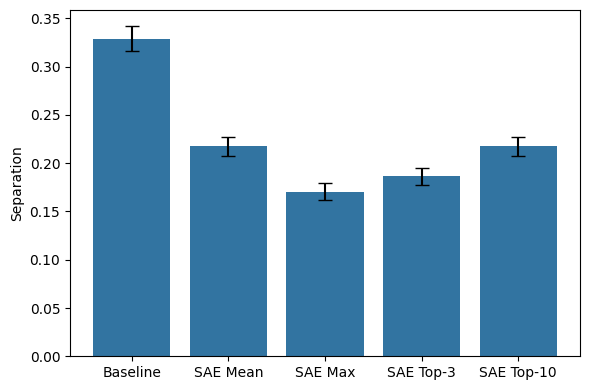

In [31]:
plot_separation([rag_stats, sae_mean_stats, sae_max_stats, sae_top3_stats, sae_top10_stats], ['Baseline', 'SAE Mean', 'SAE Max', 'SAE Top-3', 'SAE Top-10'])

In [33]:
import numpy as np
from collections import defaultdict

# 1) Run RAG + SAE on all examples and store results
results = []
for ex in examples_1:
    context = ex["context"]
    pos_q = ex["pos_query"]
    neg_q = ex["neg_query"]

    # Now each returns a single normalized separation score
    rag_sep = rag_separation(context, pos_q, neg_q)
    sae_sep = sae_separation(context, pos_q, neg_q, 'mean')

    results.append({
        "context": context,
        "pos_query": pos_q,
        "neg_query": neg_q,
        "rag_sep": rag_sep,
        "sae_sep": sae_sep,
    })

# 2) Group by context (conversation)
groups = defaultdict(list)
for r in results:
    groups[r["context"]].append(r)

# 3) For each group, compute mean separation for RAG and SAE
group_summaries = []

for context, group in groups.items():
    rag_sep_vals = [g["rag_sep"] for g in group]
    sae_sep_vals = [g["sae_sep"] for g in group]

    if not rag_sep_vals or not sae_sep_vals:
        continue

    rag_mean_sep = float(np.mean(rag_sep_vals))
    sae_mean_sep = float(np.mean(sae_sep_vals))

    group_summaries.append({
        "context": context,
        "group": group,
        "rag_sep": rag_mean_sep,
        "sae_sep": sae_mean_sep,
        "delta": sae_mean_sep - rag_mean_sep,  # how much SAE beats RAG (if positive)
    })

# 4) Filter to where SAE outperforms RAG and sort by how much
better_for_sae = [g for g in group_summaries if g["sae_sep"] > g["rag_sep"]]
better_for_sae.sort(key=lambda g: g["delta"], reverse=True)

# 5) Pretty-print the cases where SAE > RAG
for g in better_for_sae:
    print("=" * 80)
    print("Context (conversation):")
    print(g["context"])
    print()
    print(f"RAG mean separation: {g['rag_sep']:.4f}")
    print(f"SAE mean separation: {g['sae_sep']:.4f}")
    print(f"SAE - RAG          : {g['delta']:.4f}")

    print("\nPairs (pos / neg) and per-pair separations:")
    for r in g["group"]:
        print(
            f"  [RAG_sep={r['rag_sep']:.4f}, SAE_sep={r['sae_sep']:.4f}]\n"
            f"    pos: {r['pos_query']}\n"
            f"    neg: {r['neg_query']}"
        )
    print()


Context (conversation):
User: I'm rebuilding my PC and need a good CPU for programming.
Assistant: The Ryzen 7 series is a great option—excellent multithreaded performance.

RAG mean separation: -0.0270
SAE mean separation: 0.2733
SAE - RAG          : 0.3003

Pairs (pos / neg) and per-pair separations:
  [RAG_sep=-0.0270, SAE_sep=0.2733]
    pos: Which CPU did you say is a good option for programming?
    neg: Which programming option did you say is good for the CPU?

Context (conversation):
User: I'm trying intermittent fasting but don't know where to begin.
Assistant: Begin with a 14:10 schedule and see how your body responds.

RAG mean separation: 0.0340
SAE mean separation: 0.2444
SAE - RAG          : 0.2105

Pairs (pos / neg) and per-pair separations:
  [RAG_sep=0.0340, SAE_sep=0.2444]
    pos: What fasting schedule did you say I should begin with?
    neg: What schedule did you say should begin fasting after I eat?

Context (conversation):
User: I’m trying to choose between airli

# Legacy

In [26]:
import numpy as np
from collections import defaultdict

# 1) Run RAG + SAE on all examples and store results
results = []
for ex in examples:
    context = ex["context"]
    pos_q = ex["pos_query"]
    neg_q = ex["neg_query"]

    rag_pos, rag_neg = rag_similarity(context, pos_q, neg_q)
    sae_pos, sae_neg = sae_similarity(context, pos_q, neg_q, 'max')

    results.append({
        "context": context,
        "pos_query": pos_q,
        "neg_query": neg_q,
        "rag_pos": rag_pos,
        "rag_neg": rag_neg,
        "sae_pos": sae_pos,
        "sae_neg": sae_neg,
    })

# 2) Group by context (conversation)
groups = defaultdict(list)
for r in results:
    groups[r["context"]].append(r)

# 3) For each group, compute separation for RAG and SAE
group_summaries = []

for context, group in groups.items():
    rag_pos_vals = [g["rag_pos"] for g in group]
    rag_neg_vals = [g["rag_neg"] for g in group]
    sae_pos_vals = [g["sae_pos"] for g in group]
    sae_neg_vals = [g["sae_neg"] for g in group]

    # Need at least one related and one unrelated to define a separation
    if not rag_pos_vals or not rag_neg_vals or not sae_pos_vals or not sae_neg_vals:
        continue

    rag_sep = np.mean(rag_pos_vals) - np.mean(rag_neg_vals)
    sae_sep = np.mean(sae_pos_vals) - np.mean(sae_neg_vals)

    group_summaries.append({
        "context": context,
        "group": group,
        "rag_sep": rag_sep,
        "sae_sep": sae_sep,
        "delta": sae_sep - rag_sep,  # how much SAE beats RAG (if positive)
    })

# 4) Filter to where SAE outperforms RAG and sort by how much
better_for_sae = [g for g in group_summaries if g["sae_sep"] > g["rag_sep"]]
better_for_sae.sort(key=lambda g: g["delta"], reverse=True)

# 5) Pretty-print the cases where SAE > RAG
for g in better_for_sae:
    print("=" * 80)
    print("Context (conversation):")
    print(g["context"])
    print()
    print(f"RAG separation: {g['rag_sep']:.4f}")
    print(f"SAE separation: {g['sae_sep']:.4f}")
    print(f"SAE - RAG      : {g['delta']:.4f}")

    print("\nRelated (pos_query) and sims:")
    for r in g["group"]:
        print(f"  [RAG={r['rag_pos']:.4f}, SAE={r['sae_pos']:.4f}]  {r['pos_query']}")

    print("\nUnrelated (neg_query) and sims:")
    for r in g["group"]:
        print(f"  [RAG={r['rag_neg']:.4f}, SAE={r['sae_neg']:.4f}]  {r['neg_query']}")
    print()


Context (conversation):
User: I want a sci-fi novel that’s thoughtful but still fun to read. Any ideas?
Assistant: You might enjoy "The Three-Body Problem." It mixes hard science with a very engaging story.

RAG separation: 0.1755
SAE separation: 0.3364
SAE - RAG      : 0.1609

Related (pos_query) and sims:
  [RAG=0.7535, SAE=0.4608]  Which sci-fi book did you recommend that combines hard science with an engaging story?

Unrelated (neg_query) and sims:
  [RAG=0.5780, SAE=0.1244]  Which non-fiction book did you recommend for learning basic investing principles?

Context (conversation):
User: I want a compact camera for street photography, something small but with great image quality. Any suggestions?
Assistant: You might really like the Ricoh GR III. It’s very pocketable and has an excellent 28mm-equivalent lens that’s great for street shots.

RAG separation: 0.1460
SAE separation: 0.2407
SAE - RAG      : 0.0947

Related (pos_query) and sims:
  [RAG=0.7889, SAE=0.4435]  What was the sma

In [30]:
compare(
    "User: I yelled at my sister yesterday and now she won’t talk to me.\n"
    "Assistant: That sounds painful. When something can’t be taken back, the focus becomes repairing trust.\n"
    "User: I wish I could undo it.",
    "How do I deal with a mistake that I can’t take back?"
)

In [13]:
compare("He planted the seed in spring and waited months for anything to happen.",
        "She submitted her PhD application and knew the results would arrive much later.")

RAG similarity: 0.5280847636696077
SAE similarity: 0.15224242210388184


In [14]:
compare("Once the glass shattered, there was no way back.",
        "When she sent the angry email, the relationship changed permanently.")

RAG similarity: 0.4709199426788174


KeyboardInterrupt: 

In [ ]:
compare("He invested everything for a chance at a breakthrough.",
        "She stepped onto the stage knowing the risk was worth the opportunity.")

RAG similarity: 0.5718832471264863
SAE similarity: 0.534549355506897


In [10]:
compare('She closed the window because the cold wind was coming in.',
        'She shut the window to keep the chilly breeze out.')

RAG similarity: 0.9285133402558516
SAE similarity: 0.5873538255691528


In [22]:
compare('He hurried to catch the last train before midnight.',
        'He rushed to board the final train that left just before twelve.')

RAG similarity: 0.9019049688465273
SAE similarity: 0.6499947905540466


In [23]:
compare('The book was so captivating that she finished it in one night.',
        'She read the whole novel in a single evening because it was irresistible.')

RAG similarity: 0.8380246617842546
SAE similarity: 0.6573800444602966


In [24]:
compare('The dog barked loudly at the mail carrier.',
        'The dog made a racket when the postal worker approached.')

RAG similarity: 0.8239608511256304
SAE similarity: 0.589231014251709


In [25]:
compare('The cat slept on the warm radiator.',
        'Quantum computers require extremely low temperatures to operate.')

RAG similarity: 0.5298888996725823
SAE similarity: 0.5248370170593262


In [26]:
compare('The nebula glowed faintly as the telescope adjusted its focus.',
        'I forgot to buy onions for the pasta sauce.')

RAG similarity: 0.34518207932378536
SAE similarity: 0.383361279964447


In [27]:
compare('The café down the street started selling homemade lemonade.',
        'Saturn’s rings are mostly composed of ice particles.')

RAG similarity: 0.31755464184461646
SAE similarity: 0.31813913583755493


In [28]:
compare('My shoes got soaked when it started raining unexpectedly.',
        'The server must be restarted after applying the new kernel patch.')

RAG similarity: 0.3717168859381351
SAE similarity: 0.43883946537971497


In [29]:
compare('What if my child just refuses to take responsibility for their actions? How do I get them to understand the importance of being accountable?',
        'How many days did I spend on camping trips in the United States this year?')

RAG similarity: 0.3164769270993337
SAE similarity: 0.33727002143859863


Aún cuando están relacionados conceptualmente y no semánticamente, RAG es mejor que SAE

In [30]:
compare('If you pack too many tools into a small backpack, something essential will always get left behind.',
        'A neural network with fixed width can’t memorize new patterns without forgetting some of the old ones.')

RAG similarity: 0.4902988564590743
SAE similarity: 0.3685685396194458


In [31]:
compare('A single spark landing in dry grass can turn into a wildfire by nightfall.',
        'One unstable nucleotide in a cell can initiate a cascade of replication errors.')

RAG similarity: 0.540741589430252
SAE similarity: 0.47643065452575684


In [32]:
compare('Watering a plant twice doesn’t make it grow twice as fast.',
        'Doubling your training epochs rarely doubles your model’s accuracy.')

RAG similarity: 0.5917122431442312
SAE similarity: 0.3543633222579956
